# Hierarchichal Bayesian Model

In [1]:
import jax
jax.default_backend()
jax.devices()

2023-01-19 16:28:29.693776: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.0/lib64:
2023-01-19 16:28:29.795911: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.0/lib64:
2023-01-19 16:28:29.796656: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.0/lib64:


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [48]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import special, stats
import numpy as np
from numpy.random import normal


#import theano


import datetime
print(f"Last Run {datetime.datetime.now()}")

Last Run 2023-01-19 17:19:30.234478


# Import data

In [4]:
import os
import requests
import pandas as pd
import warnings
from datetime import datetime

def download_files(filepath, N):
    url = f"https://www.football-data.co.uk/mmz4281/{filepath}/{N}.csv"
    response = requests.get(url)
    directory = "/home/data-scientist/Documents/Football Modelling/Data"
    os.makedirs(directory, exist_ok=True)
    file_name = f"{filepath}_{N}_{datetime.now().strftime('%Y-%m-%d %H-%M-%S')}.csv"
    open(os.path.join(directory, file_name), "wb").write(response.content)
    df = pd.read_csv(os.path.join(directory, file_name),encoding='latin1')
    return df

def data_quality_checks(df):
    if df.isnull().sum().sum() > 0:
        raise ValueError("Dataframe contains missing values")
    if df.duplicated().sum() > 0:
        raise ValueError("Dataframe contains duplicates")

filepath_values = ["1819", "1920", "2021", "2122", "2223"]
N_values = ["E0", "E1", "E2", "E3", "EC"]
directory = "/home/data-scientist/Documents/Football Modelling/Data"


final_df = pd.DataFrame()
for filepath in filepath_values:
    for N in N_values:
        df = download_files(filepath, N)
        try:
            data_quality_checks(df)
        except ValueError as e:
            warnings.warn(f"{filepath}_{N} has {e}")
        final_df = pd.concat([final_df, df], ignore_index=True)
final_df.to_csv(os.path.join(directory, f"final_df_{datetime.now().strftime('%Y-%m-%d %H-%M-%S')}.csv"), index=False)


/tmp/ipykernel_62397/2767912135.py:35: UserWarning: 1819_E1 has Dataframe contains missing values
  warnings.warn(f"{filepath}_{N} has {e}")
/tmp/ipykernel_62397/2767912135.py:35: UserWarning: 1819_E3 has Dataframe contains missing values
  warnings.warn(f"{filepath}_{N} has {e}")
/tmp/ipykernel_62397/2767912135.py:35: UserWarning: 1819_EC has Dataframe contains missing values
  warnings.warn(f"{filepath}_{N} has {e}")
/tmp/ipykernel_62397/2767912135.py:35: UserWarning: 1920_E1 has Dataframe contains missing values
  warnings.warn(f"{filepath}_{N} has {e}")
/tmp/ipykernel_62397/2767912135.py:35: UserWarning: 1920_E2 has Dataframe contains missing values
  warnings.warn(f"{filepath}_{N} has {e}")
/tmp/ipykernel_62397/2767912135.py:35: UserWarning: 1920_E3 has Dataframe contains missing values
  warnings.warn(f"{filepath}_{N} has {e}")
/tmp/ipykernel_62397/2767912135.py:35: UserWarning: 1920_EC has Dataframe contains missing values
  warnings.warn(f"{filepath}_{N} has {e}")
/tmp/ipykerne

In [5]:
df = final_df

columns_to_keep = ["Div","Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR","HTHG","HTAG","HTR"]
df = df[columns_to_keep].copy()
df["Date"] = pd.to_datetime(df['Date'])
df["Month"] = df['Date'].dt.month
df["Game"] = df.apply(lambda x: x["HomeTeam"] + " vs " + x["AwayTeam"], axis=1)


df.loc[:, 'Total Goals'] = df[['FTHG', 'FTAG']].sum(axis=1)
df.loc[:, 'Total FHG'] = df[['HTHG', 'HTAG']].sum(axis=1)
df.loc[:, 'Both Teams Score'] = np.where((df['FTHG'] > 0) & (df['FTAG'] > 0), 1, 0)
df.loc[:, 'Under 2.5 Goals'] = np.where((df['Total Goals'] < 2.5) , 1, 0)
df.loc[:, 'Over 2.5 Goals'] = np.where((df['Total Goals'] > 2.5) , 1, 0)
df.loc[:, 'Under 0.5 Goals'] = np.where((df['Total Goals'] < 0.5) , 1, 0)
df.loc[:, 'Over 0.5 Goals'] = np.where((df['Total Goals'] > 0.5) , 1, 0)
df.loc[:, 'Under 1.5 Goals'] = np.where((df['Total Goals'] < 1.5) , 1, 0)
df.loc[:, 'Over 1.5 Goals'] = np.where((df['Total Goals'] > 1.5) , 1, 0)
df.loc[:, 'Under 3.5 Goals'] = np.where((df['Total Goals'] < 3.5) , 1, 0)
df.loc[:, 'Over 3.5 Goals'] = np.where((df['Total Goals'] > 3.5) , 1, 0)
df.loc[:, 'Under 4.5 Goals'] = np.where((df['Total Goals'] < 4.5) , 1, 0)
df.loc[:, 'Over 4.5 Goals'] = np.where((df['Total Goals'] > 4.5) , 1, 0)
df.loc[:, 'First Half Goals 0.5'] = np.where((df['Total FHG'] < 0.5) , 1, 0)
df.loc[:, 'First Half Goals 1.5'] = np.where((df['Total FHG'] < 1.5) , 1, 0)
df['Div'] = df['Div'].astype('category')
df['HomeTeam'] = df['HomeTeam'].astype('category')
df['AwayTeam'] = df['AwayTeam'].astype('category')
df['Game'] = df['Game'].astype('category')




/home/data-scientist/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '18/08/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/data-scientist/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '19/08/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/data-scientist/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '20/08/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/data-scientist/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Par

In [57]:
df_prior = df.loc[df['Date'] <= (max(df['Date']) - pd.Timedelta(days=720))]
df_observed = (df.loc[df['Date'] >= (max(df['Date']) - pd.Timedelta(days=720))])

print(df_observed.shape)
print(df_prior.shape)

(2826, 27)
(8461, 27)


In [58]:
df_observed["HomeTeam"].value_counts().to_csv('homecounts')

# generic model

In [59]:
# Hierarchies
HomeTeam_idx = df_observed.HomeTeam.cat.codes.values
HomeTeam_codes = df_observed.HomeTeam.cat.categories
Div_idx = df_observed.Div.cat.codes.values
Div_codes = df_observed.Div.cat.categories
Game_idx = df_observed.Game.cat.codes.values
Game_codes = df_observed.Game.cat.categories

n_HomeTeam = len(HomeTeam_idx)
n_Div = Div_codes.size
n_Game = Game_codes.size

# Parameters
BothTeamsScore_game = np.array(df_observed["Both Teams Score"])
U2_5G_game = np.array(df_observed["Under 2.5 Goals"])
U0_5G_game = np.array(df_observed["Under 0.5 Goals"])
U1_5G_game = np.array(df_observed["Under 1.5 Goals"])
U3_5G_game = np.array(df_observed["Under 3.5 Goals"])
U4_5G_game = np.array(df_observed["Under 4.5 Goals"])
FH_U0_5G_game = np.array(df_observed['First Half Goals 0.5'])
FH_U1_5G_game = np.array(df_observed['First Half Goals 1.5'])

# unique_teams = np.unique(Div_idx)
# num_unique_teams = len(unique_teams)
# print(num_unique_teams)


print('n_HomeTeam',n_HomeTeam)
print('n_Div', n_Div)

print(n_HomeTeam)

n_HomeTeam 2826
n_Div 5
2826


In [60]:
with pm.Model() as hierarchical_model:
    
    # Hyper parameters
    omega = pm.Beta('omega', 1, 1)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    # Parameters for categories (Divisions)
    omega_c = pm.Beta('omega_c',
                       omega * (kappa-2) + 1, (1-omega) * (kappa-2) + 1,
                       shape = n_Div)
    
    kappa_c_minus2 = pm.Gamma('kappa_c_minus2',
                              0.01, 0.01,
                              shape = n_Div)
    
    kappa_c = pm.Deterministic('kappa_c', kappa_c_minus2 + 2)
    
    # parameter estimates at home team level
    theta = pm.Beta('theta',
                     omega_c[Div_idx] * (kappa_c[Div_idx]-2) + 1,
                    (1-omega_c[Div_idx]) * (kappa_c[Div_idx]-2) + 1,
                     shape = n_HomeTeam)
    
    y = pm.Bernoulli('y', theta[HomeTeam_idx], observed=BothTeamsScore_game)
    
from graphviz import Digraph




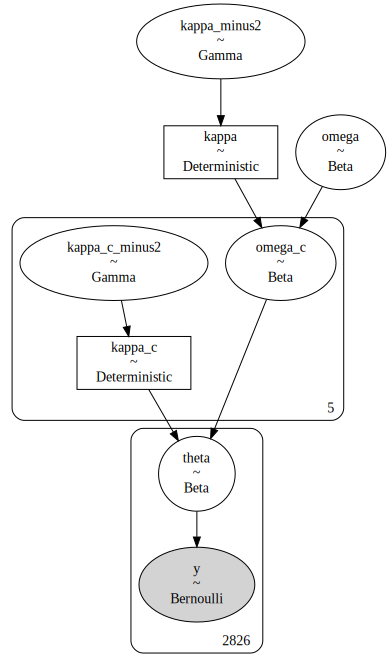

In [64]:
#graph = pm.model_to_graphviz(hierarchical_model)
#graph
#graph.format = 'png'
#graph.render('hierarchical_model')
pm.model_to_graphviz(hierarchical_model)

# MCMC Sampling

In [63]:
with hierarchical_model:
    trace = pm.sample(draws=1000, tune=3000, target_accept=0.95, cores=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, kappa_minus2, omega_c, kappa_c_minus2, theta]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 3896 seconds.


## Sample data storage 

In [ ]:
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace)
    

In [ ]:
with hierarchical_model:
    prior_predictive = pm.sample_prior_predictive(samples=2000)


In [ ]:
inference_data = pm.to_inference_data(trace=trace, *, prior=prior_predictive, posterior_predictive=ppc)


# Model Diagnostics: Convergence

array([[<AxesSubplot:title={'center':'omega'}>,
        <AxesSubplot:title={'center':'omega'}>],
       [<AxesSubplot:title={'center':'kappa_minus2'}>,
        <AxesSubplot:title={'center':'kappa_minus2'}>],
       [<AxesSubplot:title={'center':'omega_c'}>,
        <AxesSubplot:title={'center':'omega_c'}>],
       [<AxesSubplot:title={'center':'kappa_c_minus2'}>,
        <AxesSubplot:title={'center':'kappa_c_minus2'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'kappa'}>,
        <AxesSubplot:title={'center':'kappa'}>],
       [<AxesSubplot:title={'center':'kappa_c'}>,
        <AxesSubplot:title={'center':'kappa_c'}>]], dtype=object)

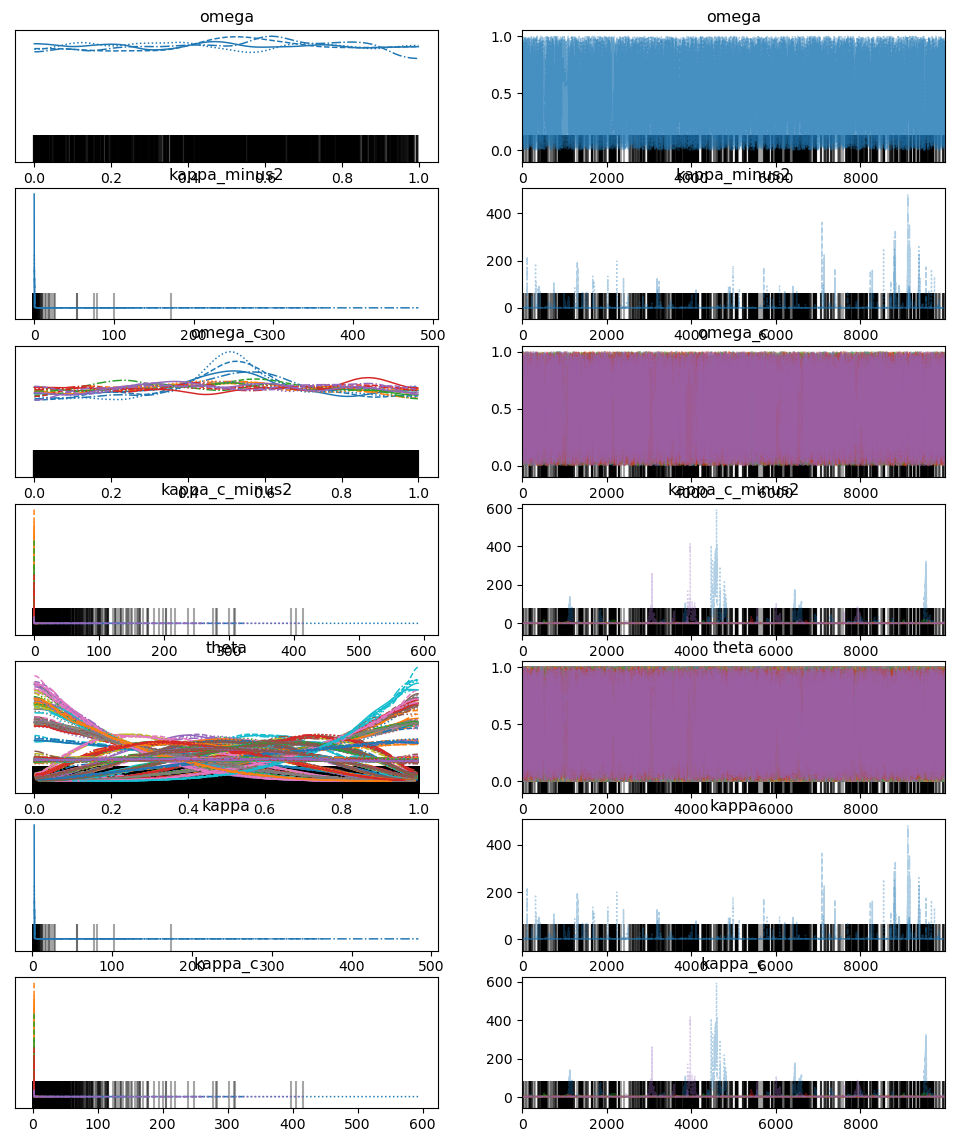

In [52]:
az.plot_trace(trace)

In [53]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.501,0.287,0.009,0.945,0.002,0.001,22545.0,14026.0,1.00
kappa_minus2,0.958,9.785,0.000,0.105,0.173,0.122,4714.0,3209.0,1.00
omega_c[0],0.506,0.277,0.067,0.998,0.002,0.001,22445.0,14618.0,1.00
omega_c[1],0.498,0.284,0.024,0.957,0.002,0.001,23763.0,21333.0,1.00
omega_c[2],0.498,0.284,0.000,0.934,0.002,0.001,26288.0,21250.0,1.00
...,...,...,...,...,...,...,...,...,...
kappa_c[0],3.932,15.454,2.000,4.100,1.044,0.739,538.0,280.0,1.01
kappa_c[1],2.040,0.314,2.000,2.011,0.008,0.006,4561.0,3542.0,1.00
kappa_c[2],2.188,1.179,2.000,2.139,0.054,0.038,1317.0,585.0,1.00
kappa_c[3],2.074,0.696,2.000,2.013,0.023,0.017,2598.0,1713.0,1.00


/home/data-scientist/anaconda3/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (333) in plot_mcse, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'omega'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'kappa_minus2'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'omega_c\n0'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'omega_c\n1'}, xlabel='Quantile', ylabel='MCSE for quantiles'>],
       [<AxesSubplot:title={'center':'omega_c\n2'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'omega_c\n3'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'omega_c\n4'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'kappa_c_minus2\n0'}, xlabel='Quantile', ylabel='MCSE for quantiles'>],
       [<AxesSubplot:title={'center':'kappa_c_minus2\n1'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'kappa_c_minus2\n2'}, xlabel='Quantile', 

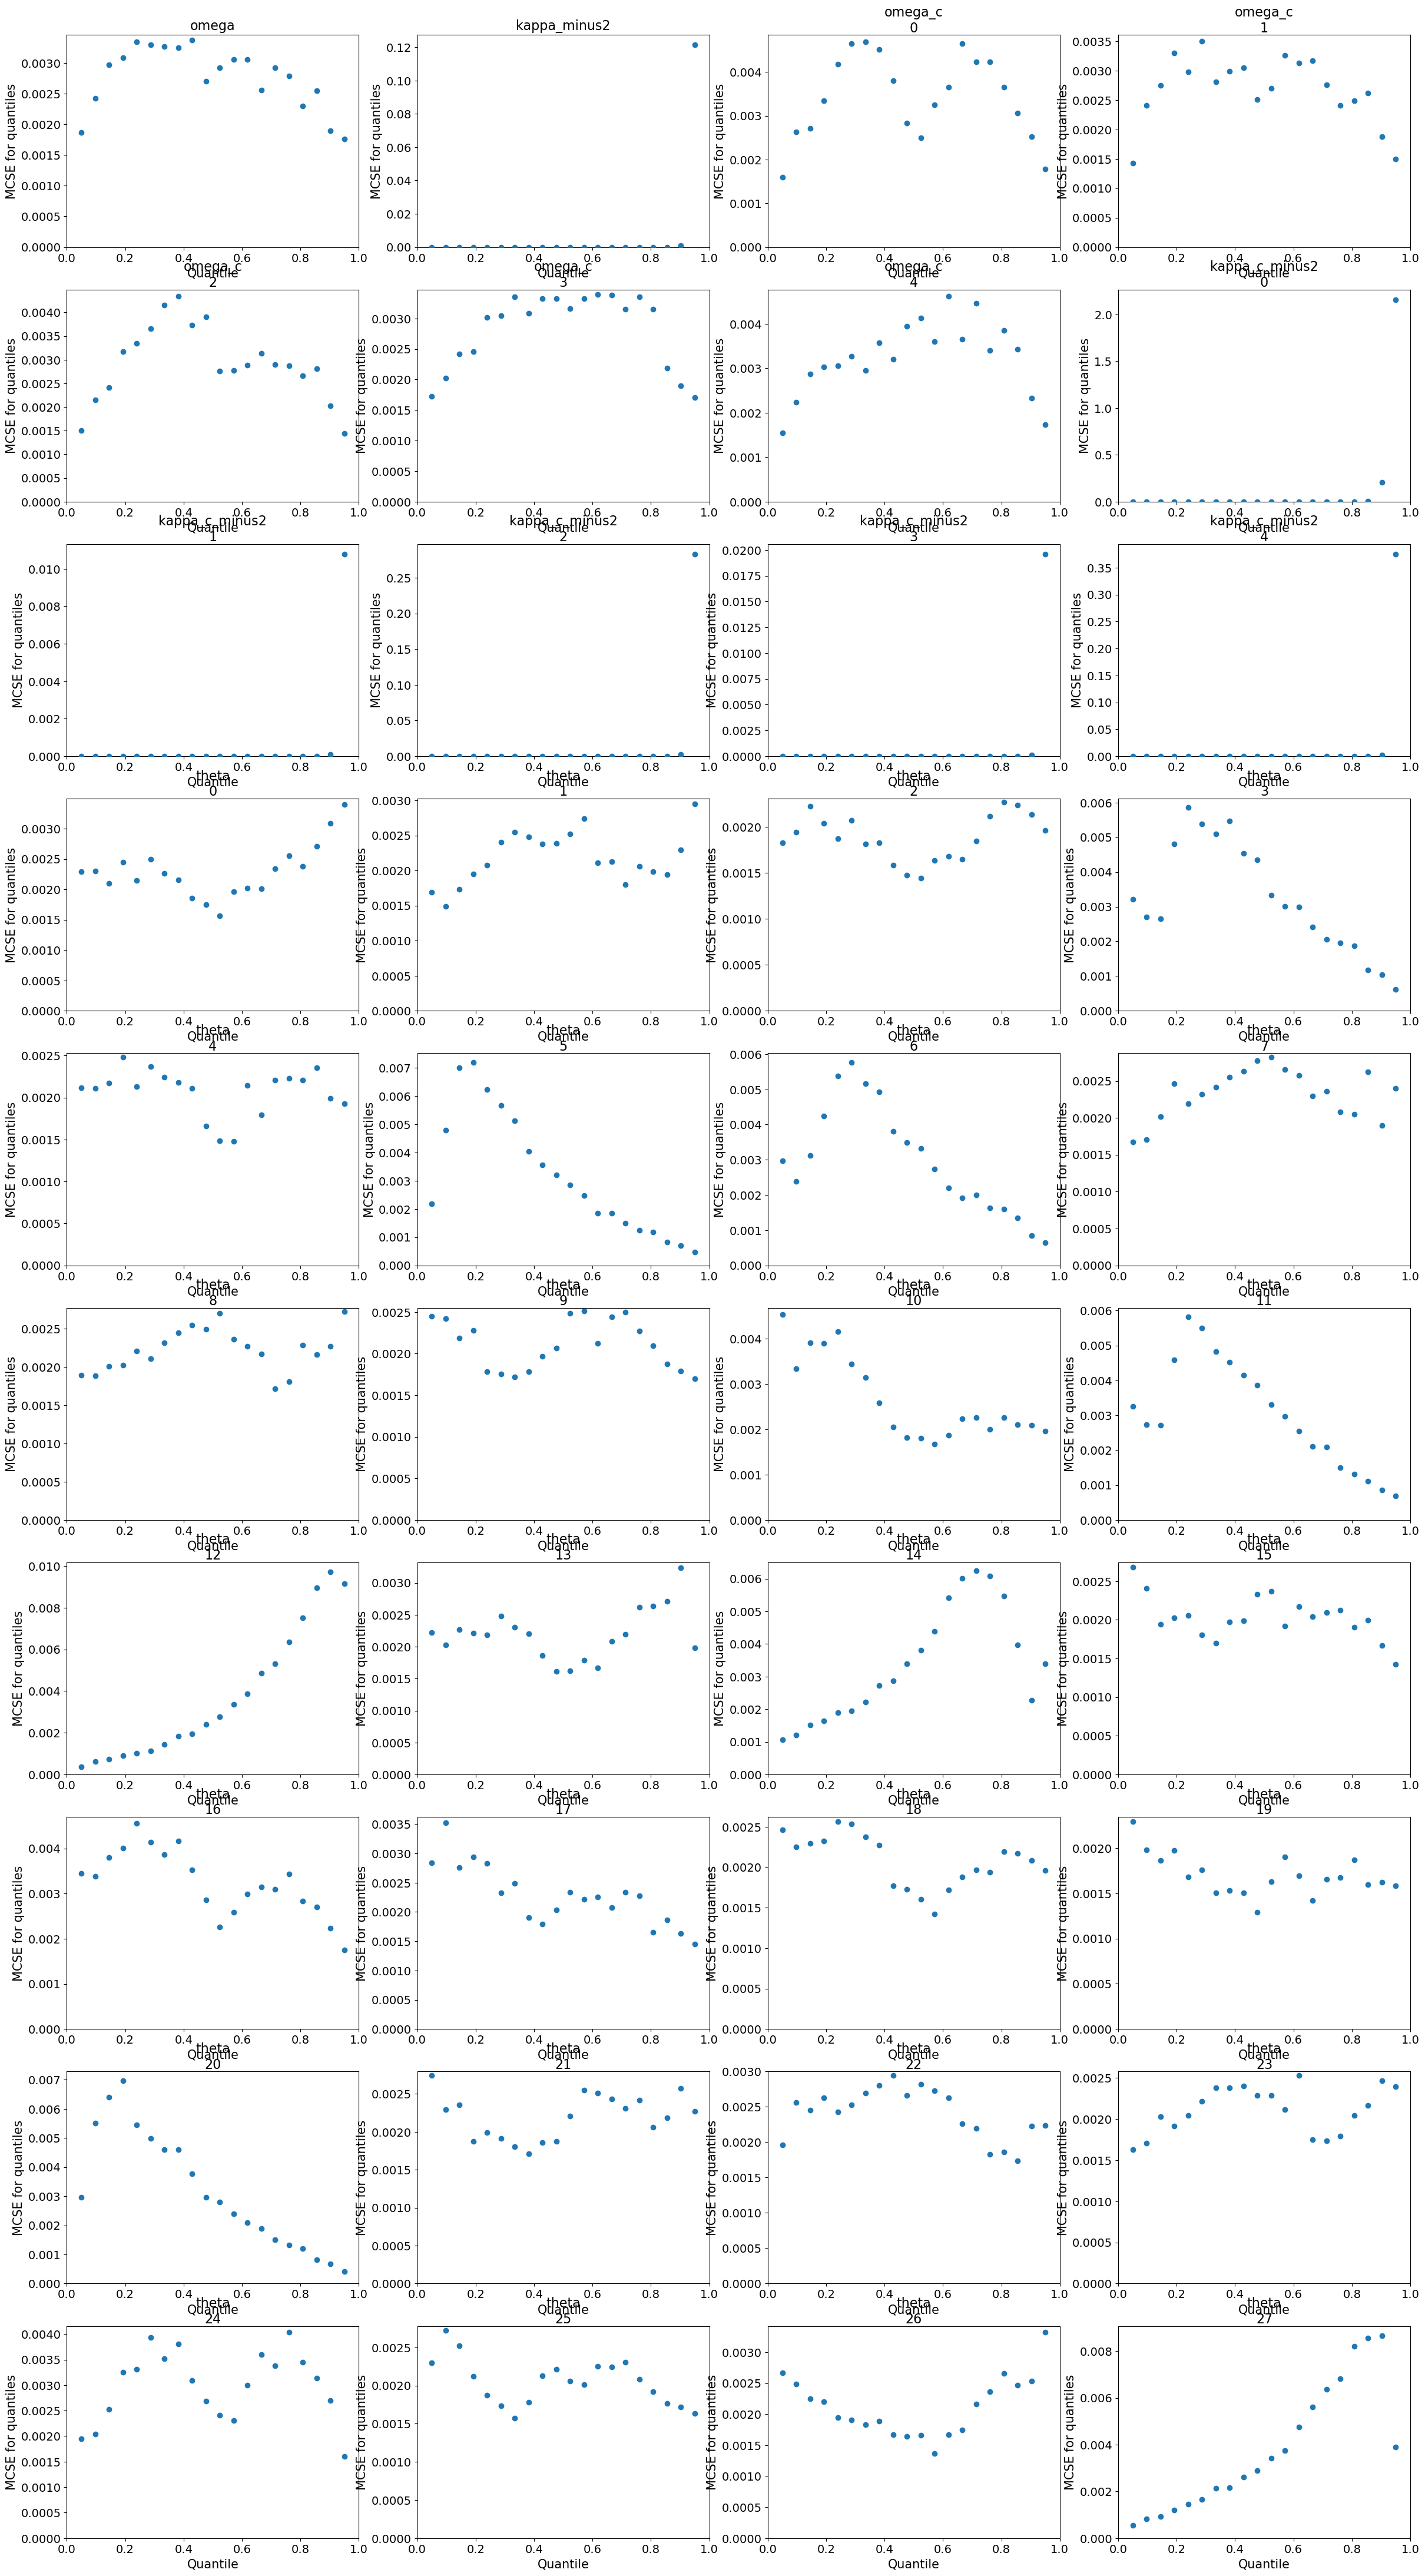

In [54]:
az.plot_mcse(trace)

/home/data-scientist/anaconda3/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (333) in plot_ess, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'omega'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'kappa_minus2'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'omega_c\n0'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'omega_c\n1'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
       [<AxesSubplot:title={'center':'omega_c\n2'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'omega_c\n3'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'omega_c\n4'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'kappa_c_minus2\n0'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
       [<AxesSubplot:title={'center':'kappa_c_minus2\n1'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'cent

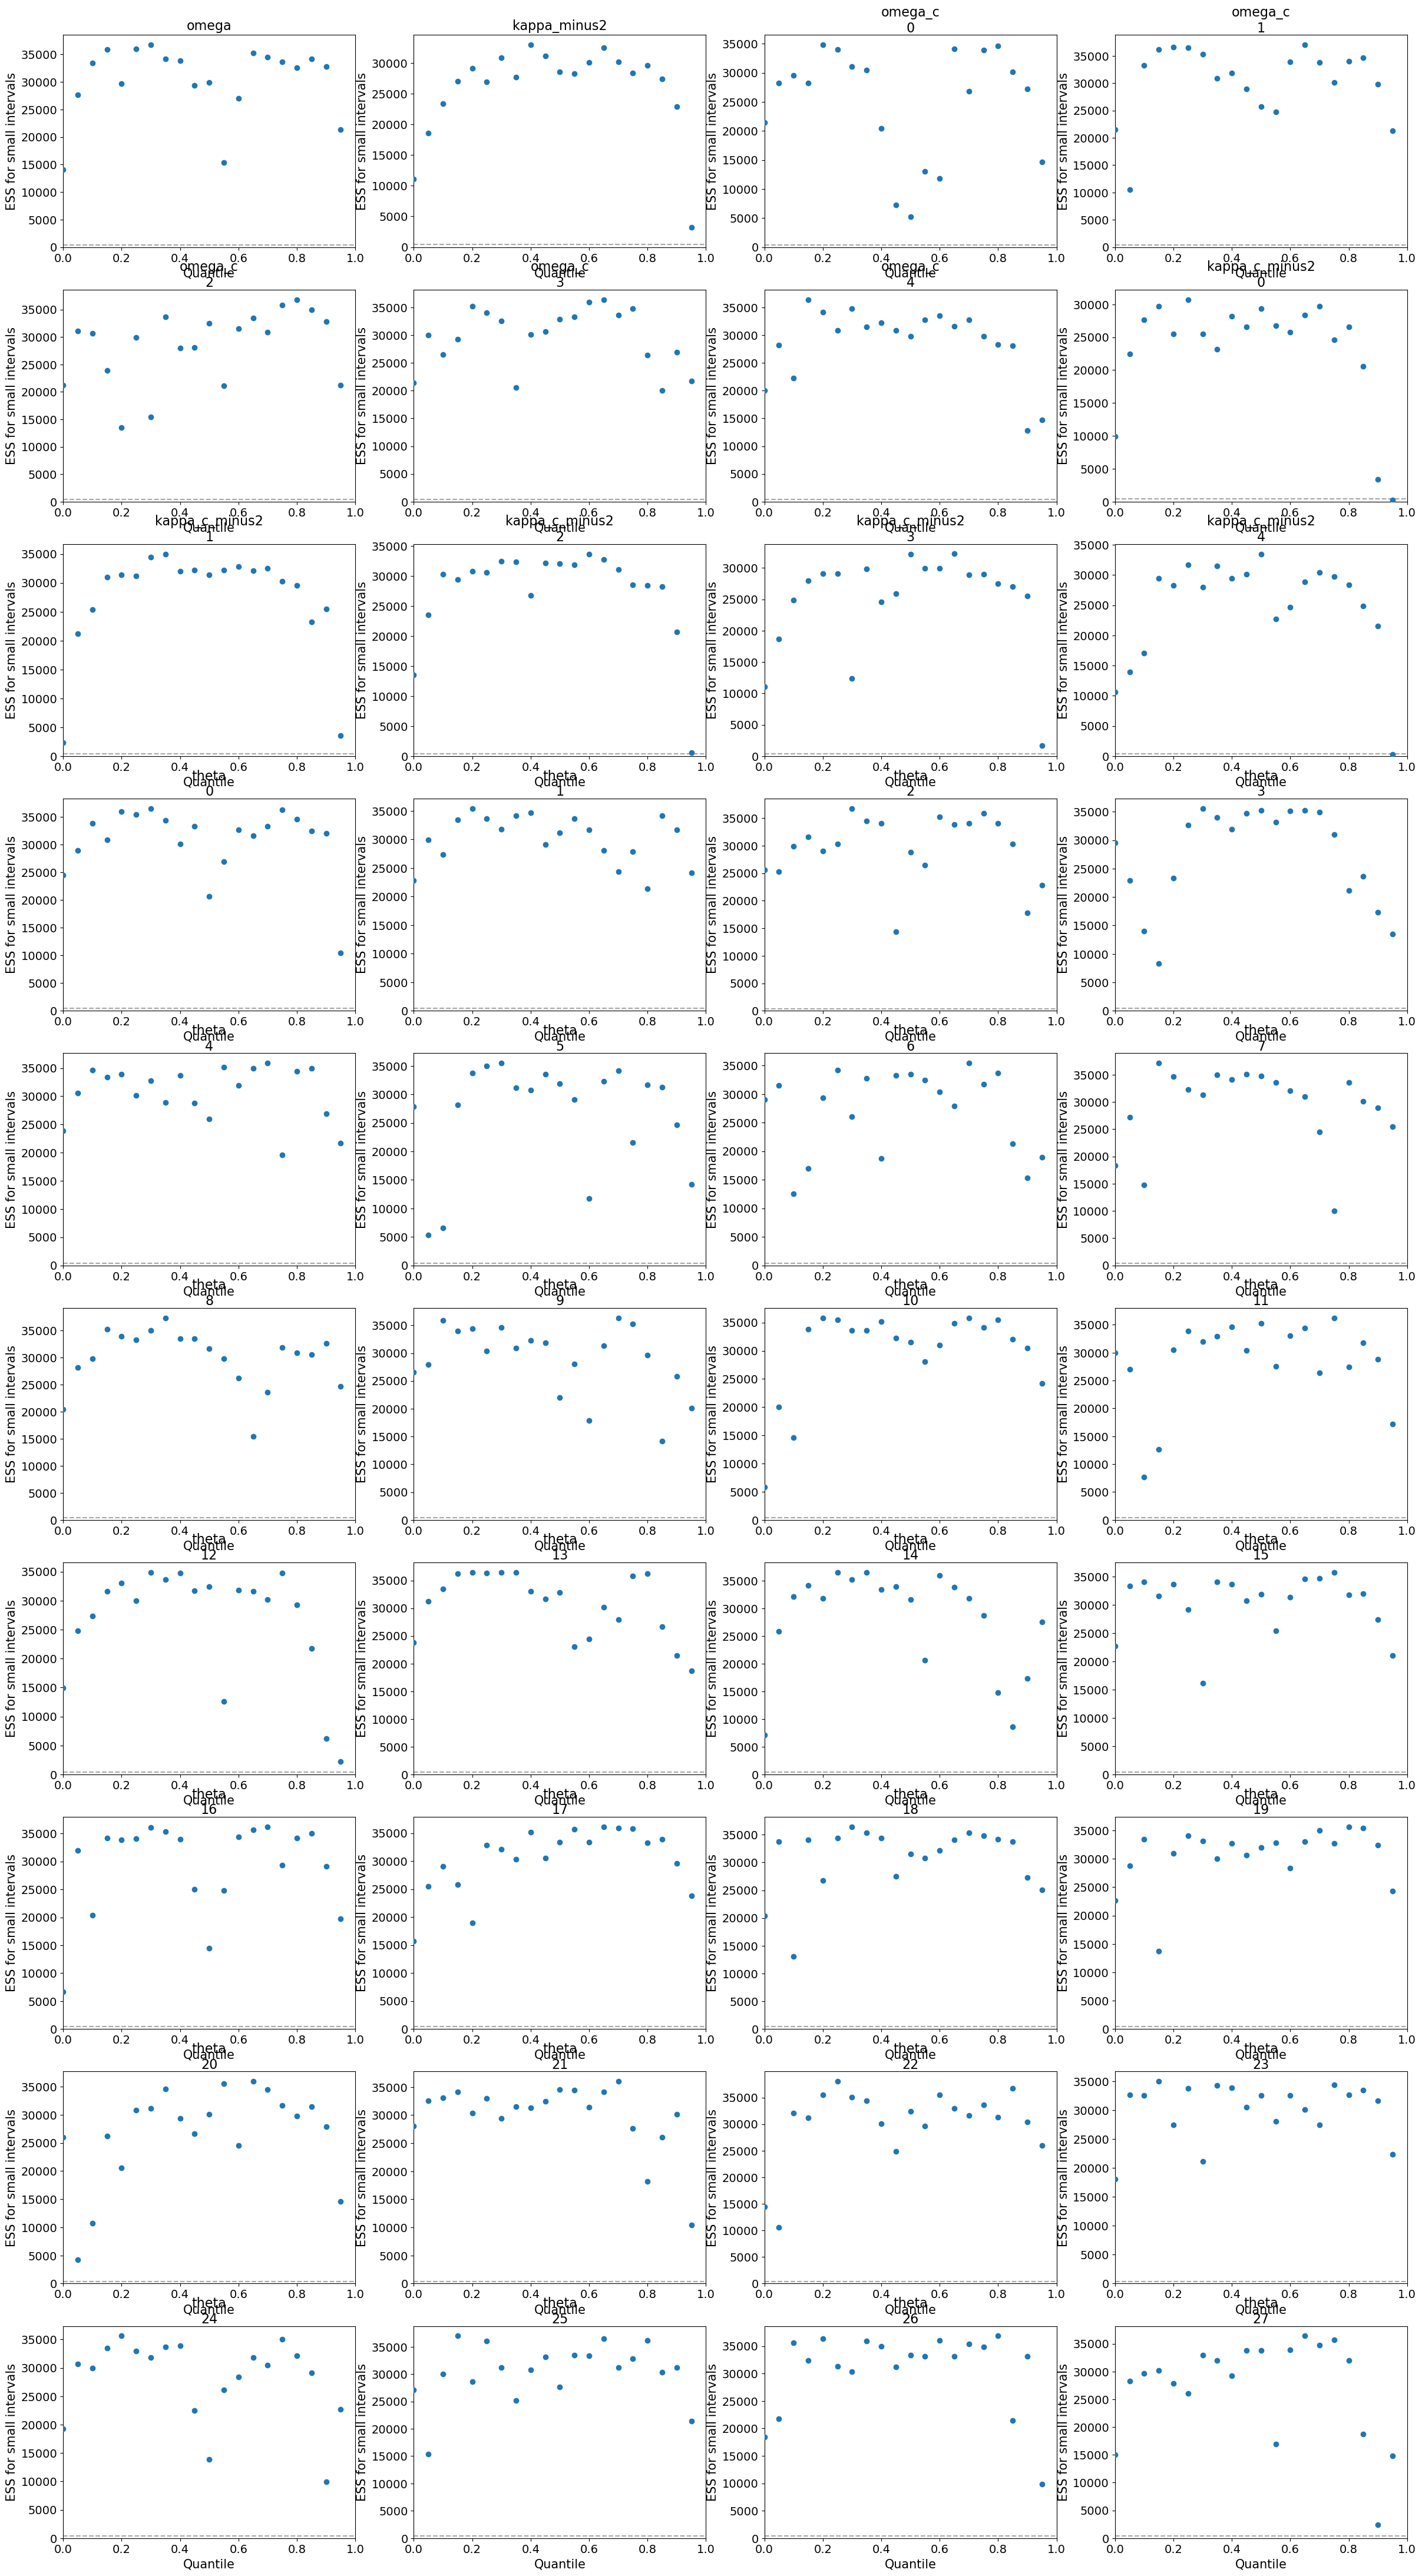

In [55]:
az.plot_ess(trace)

/home/data-scientist/anaconda3/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (333) in plot_rank, generating only 40 plots
  warnings.warn(


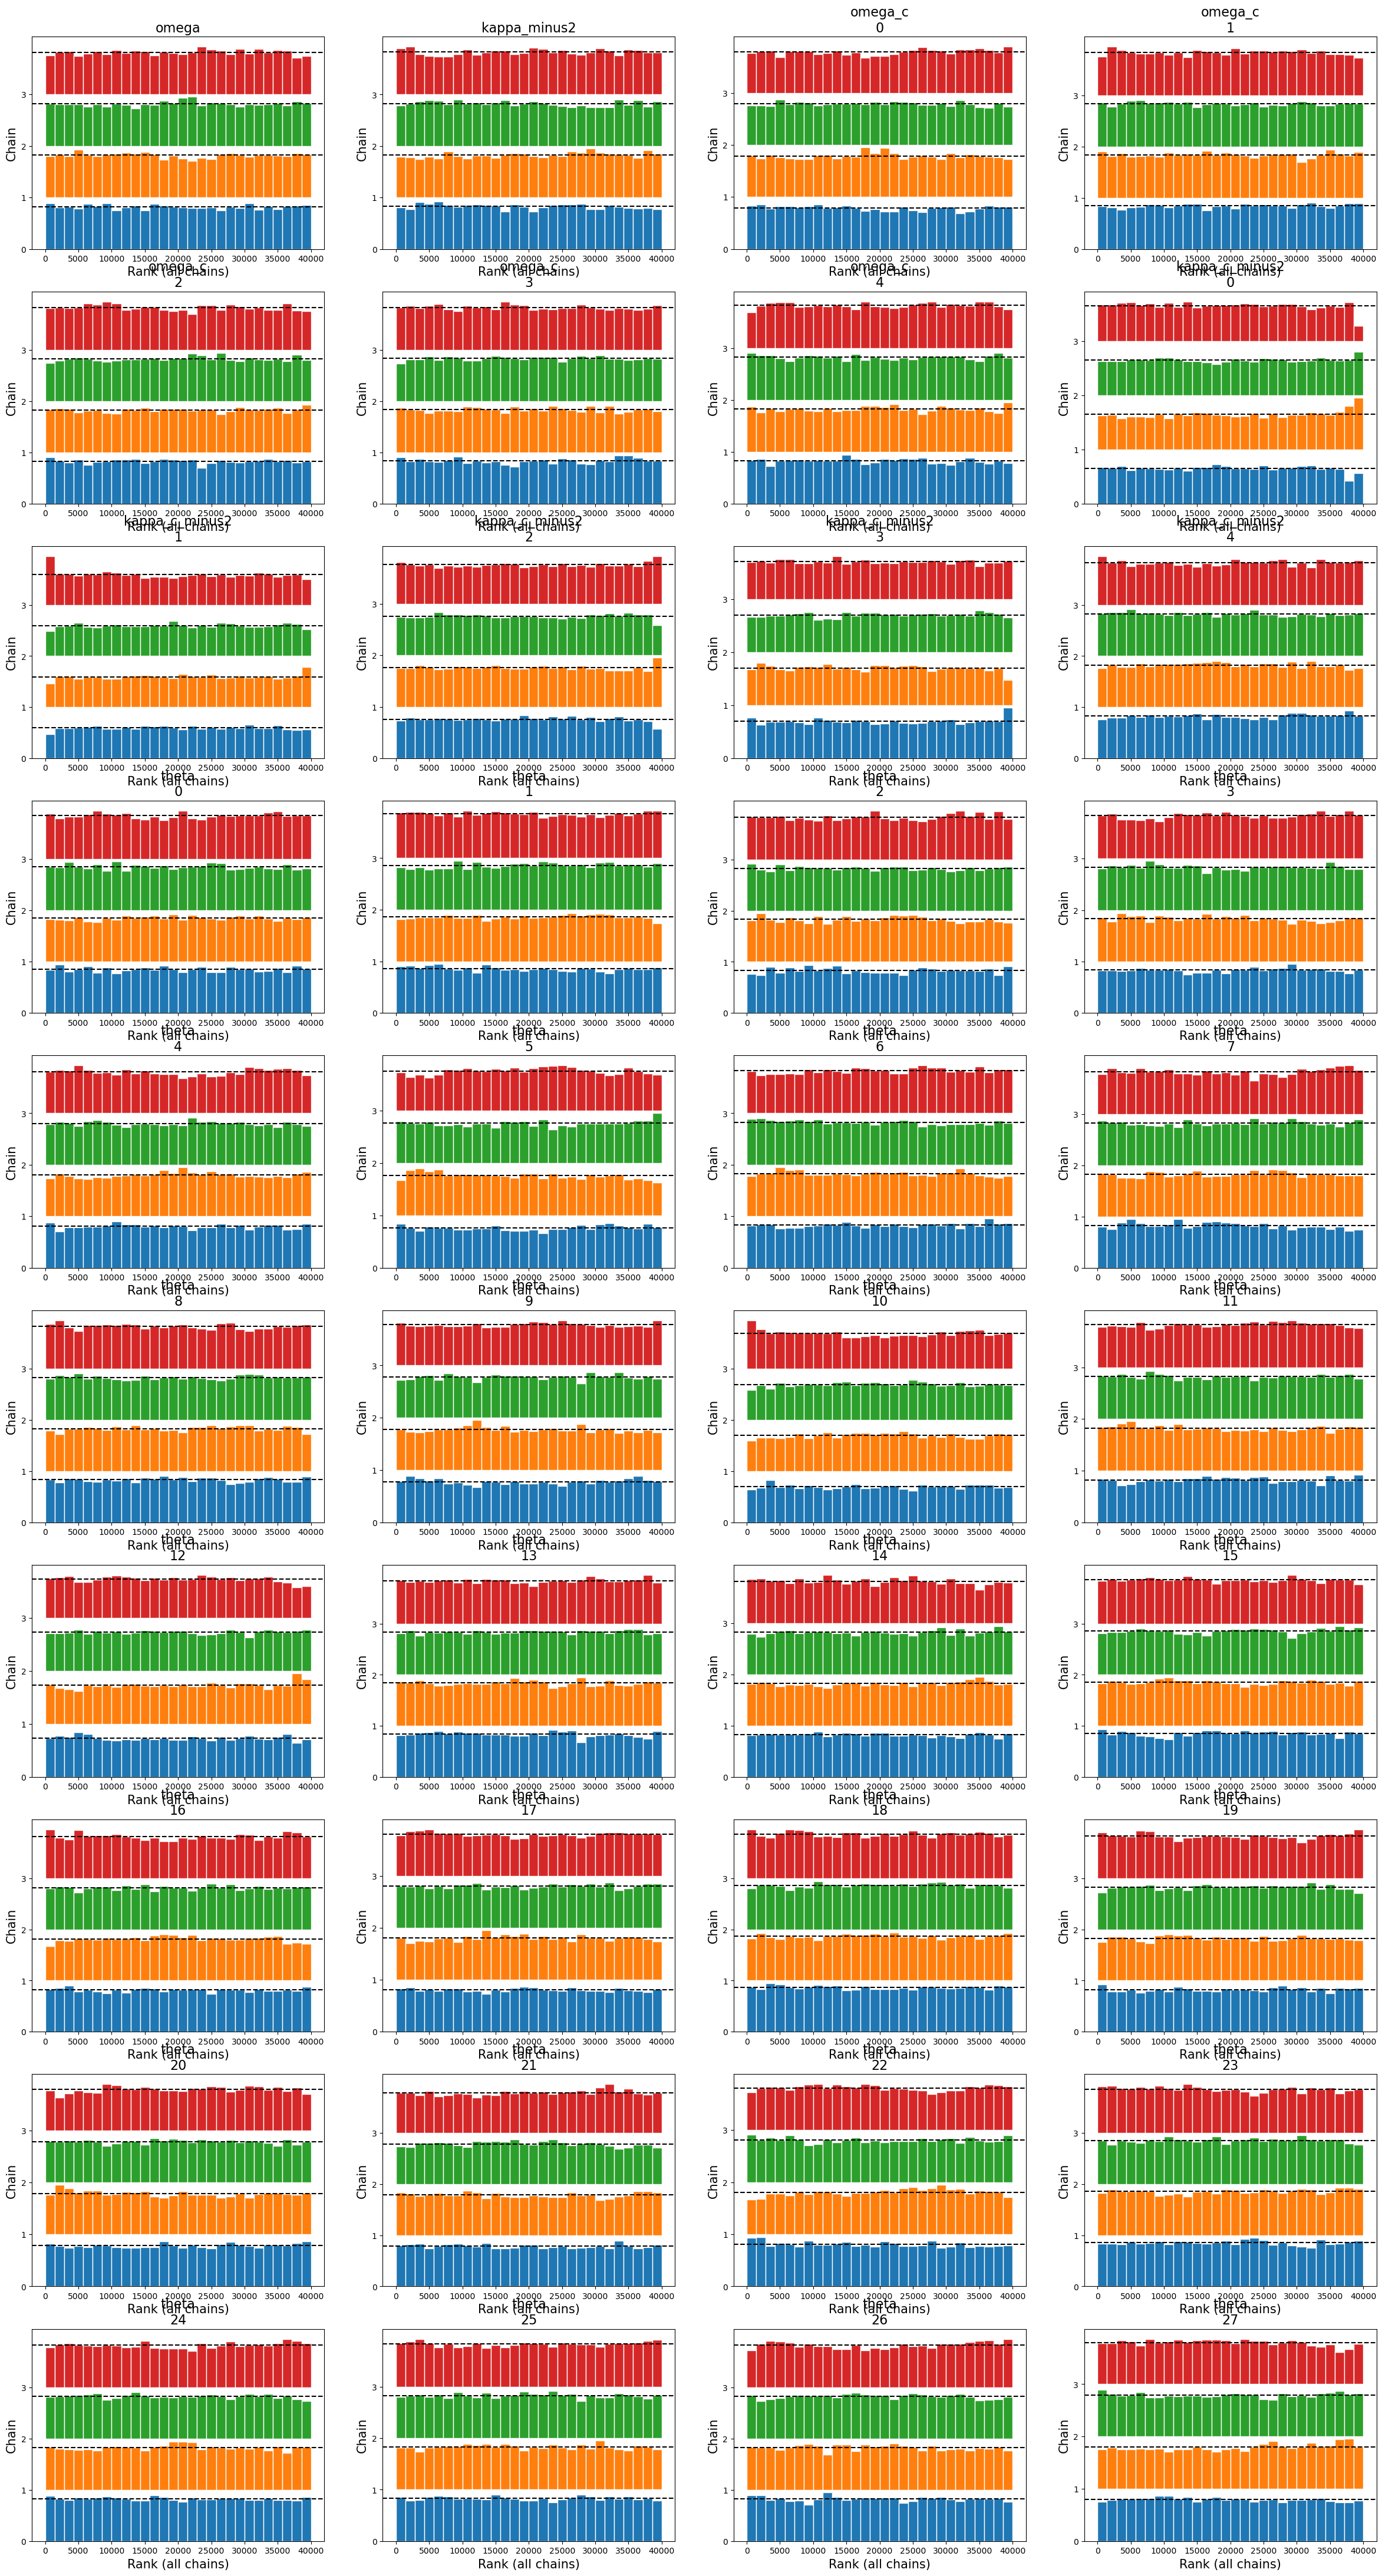

In [56]:
with hierarchical_model:
     az.plot_rank(trace)
        

# Posterior predictive checks

In [20]:
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace)
    

Sampling: [y]


In [21]:
axes = az.plot_posterior(ppc, textsize=20)

ValueError: Can not extract posterior from Inference data with groups:
	> posterior_predictive
	> observed_data! See /home/data-scientist/anaconda3/lib/python3.9/site-packages/arviz/data/converters.py for other conversion utilities.